In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install  transformers==3.3.0
!pip install contractions
!pip install torch==1.3.1

     |████████████████████████████████| 1.1MB 6.0MB/s 
     |████████████████████████████████| 1.2MB 13.9MB/s 
     |████████████████████████████████| 3.0MB 15.1MB/s 
     |████████████████████████████████| 890kB 35.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=de2e9a4797b420a3c37dc220fa7bc8fe60be7e8f05d68d97a372bd24da4661d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 266kB 5.2MB/s 
     |████████████████████████████████| 327kB 8.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=85263 sha256=0fb97378d283589fe9f2093ded9e33c72fa52057da7dc4322a2f3e04ca7ea806
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick
     |████████████████████████████████| 734.6MB 22kB/s

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer
import nltk
import contractions
import inspect
import os
import glob
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


##Data cleaning and pre-processing 

In [ ]:
neg_path="/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/Dataset-1/neg/*.txt"

pos_path="/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/Dataset-1/pos/*.txt"

current_dir = os.getcwd()
files_neg_text = glob.glob(neg_path)
files_pos_text =glob.glob (pos_path)

In [ ]:
def get_data_label(files_texts,label):
  data_array=[]
  for name in files_texts:
    try:
        with open(name) as f:
            data_neg = f.read()
            data_array.append((data_neg ,label))
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise  
  return data_array

pos_data=get_data_label(files_pos_text,1)
neg_data=get_data_label(files_neg_text,0)
whole_data_array=pos_data+neg_data


In [ ]:
# seprate the text and labels
all_text_arry=[]
label_all=[]
for i in range(len(whole_data_array)):
  all_text_arry.append(whole_data_array[i][0])
  label_all.append(whole_data_array[i][1])


In [ ]:
# Data pre-processing
def data_pre_processing(data):
  corpus = []
  for i in range(len(data)):
      review = re.sub('[^a-zA-Z]', ' ', data[i])
      review = review.lower()
      review = review.split()
      review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
      review = ' '.join(review)
      corpus.append(review)
  return corpus

process_text_data=data_pre_processing(all_text_arry)

In [ ]:
dataframe_text=pd.DataFrame(process_text_data)
dataframe_label=pd.DataFrame(label_all)
dataframe=pd.concat([dataframe_text, dataframe_label],axis=1)
dataframe.columns =["sample", "labels"] 
dataframe.head()

### Data analysis 

In [ ]:
df1=pd.DataFrame(whole_data_array)
df1.columns=['text','sentiment']
df1.head()

,text,sentiment
0,"apparently , director tony kaye had a major ba...",1
1,one of my colleagues was surprised when i told...,1
2,"after bloody clashes and independence won , lu...",1
3,the american action film has been slowly drown...,1
4,"after watching "" rat race "" last week , i noti...",1


#### Number of characters in Review

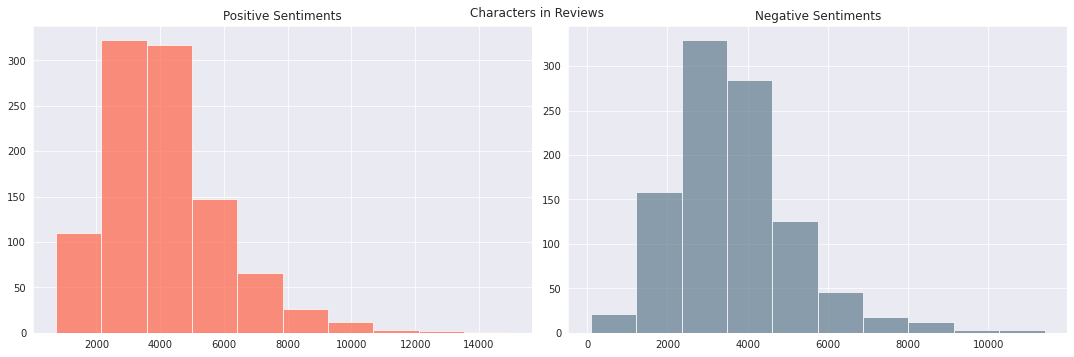

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
n_bins =10
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
tweet_len=df1[df1['sentiment']==1]['text'].str.len()
ax1.hist(tweet_len,color='tomato',bins=n_bins,alpha = 0.7)
ax1.set_title('Positive Sentiments')
tweet_len=df1[df1['sentiment']==0]['text'].str.len()
ax2.hist(tweet_len,bins=n_bins,color ='#607c8e', alpha = 0.7)                          
ax2.set_title('Negative Sentiments')
fig.suptitle('Characters in Reviews')
plt.tight_layout(True)
plt.show()

#### Number of Words in Review

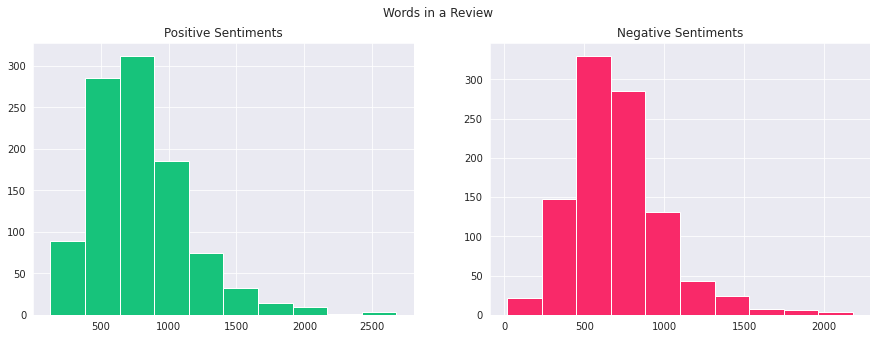

In [ ]:

import seaborn as sns
sns.set_style('darkgrid')
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
tweet_len=df1[df1['sentiment']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')
tweet_len=df1[df1['sentiment']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')
fig.suptitle('Words in a Review')
plt.show()


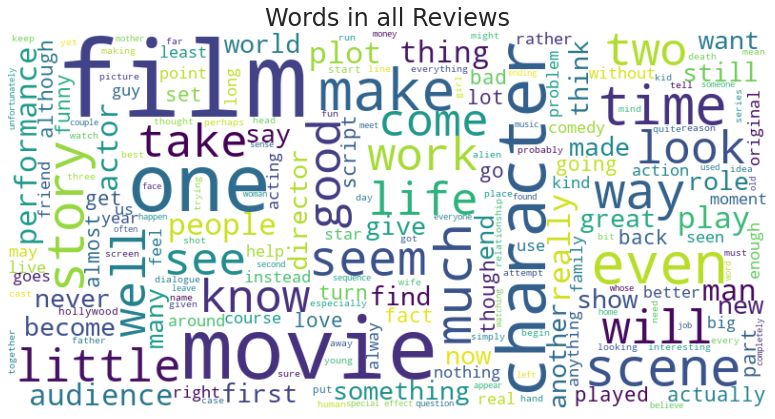

In [ ]:
from wordcloud import WordCloud
words = ' '.join([text for text in df1['text']])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all Reviews', fontsize=24)
plt.axis('off')
plt.show()

### Reviews Length

Text(0.5, 1.0, 'Length of Reviews')

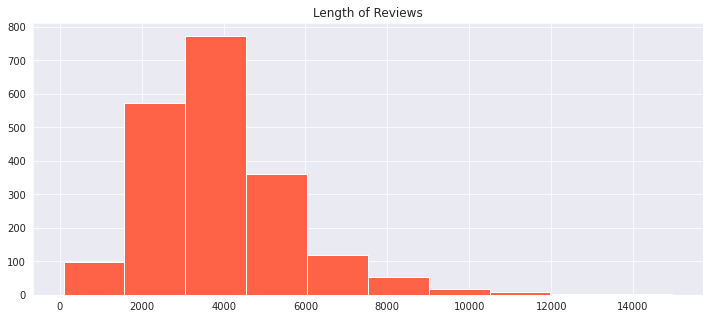

In [ ]:
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({
                                               'length_text':len(row['text'])}), axis=1)
len_train = create_len_df(df1)
len_value=len_train.values
import seaborn as sns
sns.set_style('darkgrid')
fig,(ax1)=plt.subplots(1,1,figsize=(12,5))
ax1.hist(len_value,color='#ff6347')
ax1.set_title('Length of Reviews')


##Model

In [ ]:
import re
import os
from transformers import AutoConfig, AutoModelForMaskedLM, AutoTokenizer
config = AutoConfig.from_pretrained("roberta-base")

MAX_LEN=512
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.comment_text = dataframe["sample"].tolist()
        self.targets = dataframe["labels"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)
    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            #'targets': torch.tensor(targets, dtype=torch.float)
            'targets': torch.tensor(self.targets[index], dtype=torch.long).to(device)
             }

In [ ]:
device = 'cpu'
device

'cpu'

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        config = RobertaConfig()
        config.max_position_embeddings = 512
        self.l1 = transformers.RobertaModel(config).from_pretrained("roberta-base")
        self.l2 = torch.nn.Dropout(0.2)
        self.l3 = torch.nn.Linear(768,1)

    def forward(self, ids, mask, token_type_ids):
        output_1=self.l1(ids,token_type_ids=token_type_ids)
        #print(out1.shape)
        output_2 = self.l2(output_1[1])
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)


BERTClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [ ]:
#loss function 
def loss_fn(outputs, targets):
    loss=torch.nn.BCEWithLogitsLoss()(outputs, targets)
    return loss
    

In [ ]:
LEARNING_RATE=1e-5
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## convert data into batches

In [ ]:
train_size = 0.8
train_dataset=dataframe.sample(frac=train_size,random_state=42)
test_dataset=dataframe.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))


training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

TRAIN_BATCH_SIZE=5
VALID_BATCH_SIZE=1

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_dataloader = DataLoader(training_set, **train_params)#**passing multile parameters by dic
testing_loader = DataLoader(testing_set, **test_params)


FULL Dataset: (2006, 2)
TRAIN Dataset: (1605, 2)
TEST Dataset: (401, 2)


In [ ]:
#x = iter(testing_loader).next()
#x.keys()
#x['targets'].shape
#print('id',x['ids'].shape)
#temp_v=x['ids'].squeeze()
#temp3=temp_v.unsqueeze(0)
#print('aaaa',temp3.shape)


## Model Traning

In [ ]:
def train(epoch):
    model.train()
    average_loss=0
    for i,data in enumerate(train_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        #print('targets.shape',targets.shape)
        #outputs = model(ids, mask, token_type_ids)
        outputs = model(ids.squeeze(), mask.squeeze(), token_type_ids.squeeze())
        #print(outputs)
        optimizer.zero_grad()
        # print ()
        loss = loss_fn(outputs.squeeze(), targets)
        average_loss+=loss
        if i%50==0:
            print(f'Epoch: {epoch}, Loss:  {average_loss/(i+1)}')
        loss.backward()# caculate the derivates
        optimizer.step()#upadte weight


In [ ]:
# As after each epochs i save the mdole,so previous epochs results are not listed below, the total number of epoch thats model run is 25.
EPOCHS=5
for epoch in range(EPOCHS):
    train(epoch)
torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

Epoch: 0, Loss:  0.012717818841338158
Epoch: 0, Loss:  0.11702863872051239
Epoch: 0, Loss:  0.11704670637845993
Epoch: 0, Loss:  0.13794249296188354
Epoch: 0, Loss:  0.13932406902313232
Epoch: 0, Loss:  0.12977738678455353
Epoch: 0, Loss:  0.12642702460289001
Epoch: 1, Loss:  0.005682156886905432
Epoch: 1, Loss:  0.11740991473197937
Epoch: 1, Loss:  0.0873049721121788
Epoch: 1, Loss:  0.07886090129613876
Epoch: 1, Loss:  0.06881381571292877
Epoch: 1, Loss:  0.06358517706394196
Epoch: 1, Loss:  0.06635406613349915
Epoch: 2, Loss:  0.007904920727014542
Epoch: 2, Loss:  0.03971385955810547
Epoch: 2, Loss:  0.050460271537303925
Epoch: 2, Loss:  0.05826343595981598
Epoch: 2, Loss:  0.0497916117310524
Epoch: 2, Loss:  0.04749038815498352
Epoch: 2, Loss:  0.04557253047823906
Epoch: 3, Loss:  0.00239224499091506
Epoch: 3, Loss:  0.08078628778457642
Epoch: 3, Loss:  0.061333853751420975
Epoch: 3, Loss:  0.0597403384745121
Epoch: 3, Loss:  0.057318128645420074
Epoch: 3, Loss:  0.0545632950961589

#### Save Model

In [ ]:
base_path='/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/'

In [ ]:
import datetime
mydate = datetime.datetime.now()
model_name="bert_movie_review_sentiment_anlysis"
date=mydate.strftime("%d-%b-%Y")
specification="_512.pt"
model.eval()
model_path = base_path+model_name+date+specification
print (model_path)
torch.save(model.state_dict(), model_path)

/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/bert_movie_review_sentiment_anlysis24-Feb-2021_512.pt


In [ ]:
#load the model 
model.load_state_dict(torch.load("/content/gdrive/MyDrive/Entity_extarction_aftab/experi-different-model-aftab/bert_movie_review_sentiment_anlysis24-Feb-2021_512.pt"))

<All keys matched successfully>

In [ ]:
model.to(device)

BERTClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

## validation 

In [ ]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    #softm = torch.nn.sigmoid(dim=1)
    sigmoid_v=torch.nn.Sigmoid()
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            #print(ids.shape, mask.shape,token_type_ids.shape,targets.shape)
            ids=ids.squeeze()
            mask=mask.squeeze()
            token_type_ids=token_type_ids.squeeze()
            outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))
            #print(targets.shape)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(sigmoid_v(outputs))
    return fin_outputs, fin_targets

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
for epoch in range(1):
    outputs, targets = validation(epoch)
    #targets=targets
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    precision = precision_score(targets, outputs)
    recall = recall_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(confusion_matrix(targets, outputs))
    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

Accuracy Score = 0.8678304239401496
Precision = 0.8047619047619048
Recall = 0.9337016574585635
F1 Score (Micro) = 0.8678304239401496
F1 Score (Macro) = 0.8677481782938501
[[179  41]
 [ 12 169]]


([<matplotlib.axis.YTick at 0x7fac3f8bf310>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

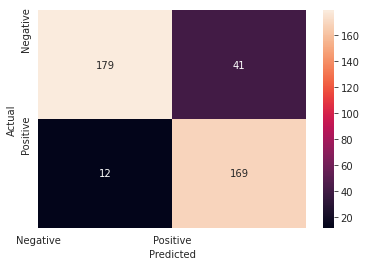

In [ ]:
sns.heatmap(confusion_matrix(targets, outputs),annot=True,fmt = '.5g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0,1],labels = ['Negative','Positive'])
plt.yticks(ticks = [0,1],labels = ['Negative','Positive'])